# 질문 답변

In [2]:
# 코랩이나 캐글을 사용한다면 이 셀의 주석을 제거하고 실행하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=7)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (272/272), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 538 (delta 165), reused 184 (delta 107), pack-reused 266
Receiving objects: 100% (538/538), 46.22 MiB | 14.22 MiB/s, done.
Resolving deltas: 100% (264/264), done.
/kaggle/working/nlp-with-transformers/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.6.1
Using datasets v1.11.0
Using haystack


In [90]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [91]:
# haystack의 로깅을 끕니다.
import logging
for module in ["farm.utils", "farm.infer", "haystack.reader.farm.FARMReader",
               "farm.modeling.prediction_head", "elasticsearch", "haystack.eval",
               "haystack.document_store.base", "haystack.retriever.base", 
               "farm.data_handler.dataset"]:
    module_logger = logging.getLogger(module)
    module_logger.setLevel(logging.ERROR)

## 1. 리뷰 기반 QA 시스템 구축하기
### 1) 데이터셋 
- get_dataset_config_names() 함수를 사용하여 어떤 서브셋을 사용할 수 있는지 확인하겠다.

In [92]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

- 여기에서는 전자 제품용 QA 시스템을 구축하는 데 초점을 맞추겠다.
- electronics 서브셋을 다운로드 하려면 load_dataset() 함수의 name 매개변수에 이 값을 전달합니다.


In [93]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

- 허브에 있는 여느 질문 답변 데이터셋과 마찬가지로 subjQA는 각 질문의 답을 중첩된 딕셔너리로 저장한다.
- 예를 들어 answers에 있는 행을 하나 확인해보겠다.

In [94]:

print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ
adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1],
'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective':
[True, True]}


- 답은 text 필드에 저장됐다.
- answer_start에 시작 문자의 인덱스가 있다.
- 이 데이터셋을 손쉽게 탐색하기 위해 다음처럼 flatten() 메서드로 중첩된 열을 펼치고 각 분할을 판다스 DataFrame로 변환하겠다.

In [95]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"{split}에 있는 질문 개수: {df['id'].nunique()}")

train에 있는 질문 개수: 1295
test에 있는 질문 개수: 358
validation에 있는 질문 개수: 255


In [96]:
qa_cols = ["title", "question", "answers.text", 
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 stars because it doesn't have a CA...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro battery I bought wouldn't hold a c...


- 이 샘플에서 몇 가지 특징이 관찰된다.
- 첫째, 질문이 문법적으로 바르지 않다.
- 전자상거래 웹사이트의 FAQ 섹션에서 흔히 있는 일이다.
- 둘째, 빈 answers.text 항목에는 리뷰에서 답을 찾지 못해 답변이 불가한 질문이 담겼다.
- 마지막으로, 시작 인덱스와 답변 길이를 사용해 리뷰에서 답변에 해당하는 텍스트를 추출할 수 있다.

In [97]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

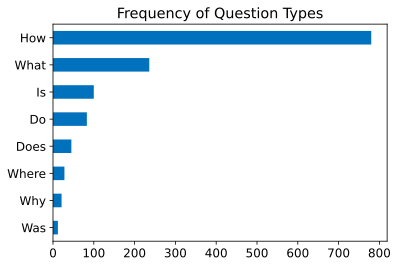

In [98]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [100]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


### 2) 텍스트에서 답 추출하기
- QA 시스템에서는 가장 먼저 고객 리뷰에 있는 텍스트에서 사용할 만한 부분을 식별해 낼 방법을 찾아야 한다.
    - 지도 학습 문제로 구성하기
    - QA 작업을 위해 텍스트를 토큰화하고 인코딩하기
    - 모델의 최대 문맥 크기를 초과하는 건 긴 텍스트 다루기 

#### 범위 분류
- 문제를 범위 분류 작업으로 구성하는 방법은 텍스트에서 답을 추출하는 가장 일반적인 방법
- 이 작업에서 모델이 예측해야 하는 레이블은 답변 범위에 해당하는 시작 토큰과 종료 토큰
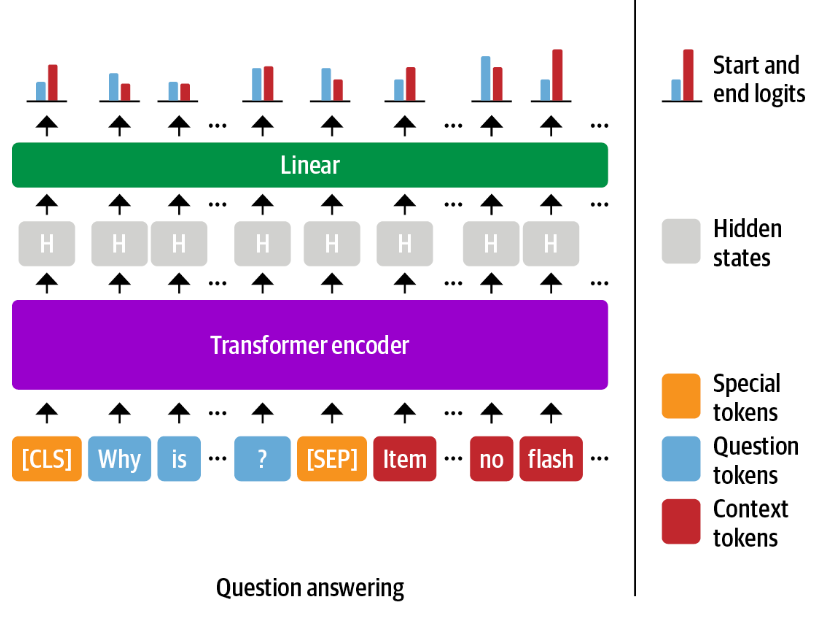



- 훈련 세트에는 비교적 적은 1,295개 샘플만 있으므로 SQuAD 같은 대규모 QA 데이터셋에서 미세 튜닝한 언어 모델로 시작하는 편이 좋다.
- 이런 모델은 대체로 독해 능력이 우수하고, 더 정확한 시스템을 구축하기 위한 좋은 기준 모델로 사용된다.
- 이전 장처럼 사전훈련된 모델을 사용해 작업에 특화된 헤드를 미세 튜닝하는 일반적인 방식과는 조금 다릅니다.
- 예를 들어 2장에서는 클래스 개수가 현재 데이터셋과 달라서 분류 헤드를 미세튜닝해야 했다.
- 그러나 추출적 QA는 레이블 구조가 데이터셋에 따라 달라지지 않기 때문에 미세튜닝한 모델로 시작해도 무방하다.

#### QA를 위한 텍스트 토큰화

In [101]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [102]:

question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [103]:
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [104]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so
about 6000 hours depending on file size. [SEP]


In [105]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750,
-5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623,
-5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0162, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None,
attentions=None)


- 헤드는 인코더의 은닉 상태를 받아 시작과 종료 범위의 로짓을 계산하는 선형 층에 해당한다.
- 이는 QA 작업을 4장의 개체명 인식과 비슷하게 분류 토큰 형태로 다룬다는 의미이다.
- 출력을 답의 범위로 변환하기 위해 먼저 시작과 종료 토큰의 로짓이 필요하다

In [106]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [107]:
print(f"입력 ID 크기: {inputs.input_ids.size()}")
print(f"시작 로짓 크기: {start_logits.size()}")
print(f"종료 로짓 크기: {end_logits.size()}")

입력 ID 크기: torch.Size([1, 28])
시작 로짓 크기: torch.Size([1, 28])
종료 로짓 크기: torch.Size([1, 28])


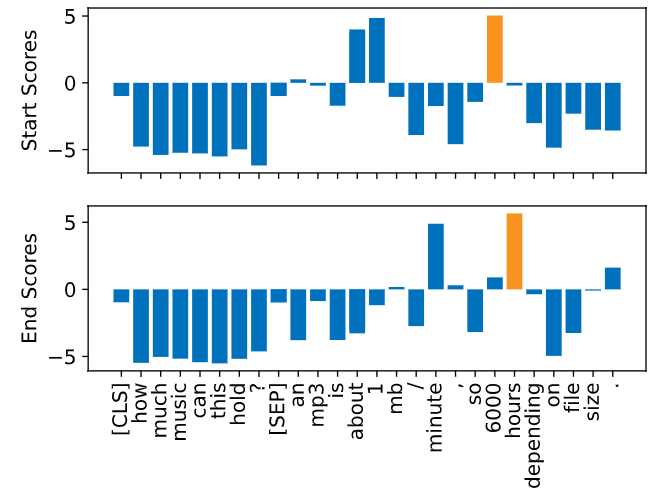

- 두 로짓(시작과 종료)은 각 입력 토큰에 연관된다.
- 큰 양수 로짓은 가능성이 높은 시작과 종료 토큰 후보에 해당한다.
- 이 예시에서는 모델이 숫자 1과 6,000에 가장 높은 시작 토큰을 로짓 할당했다.
- 질문이 어떤 양에 관한 것이므로 이해된다.
- 마찬가지로 로짓이 가장 높은 종료 토큰은 minute과 hours이다.
- 최종 답을 얻기 위해 시작 토큰과 종료 토큰의 로짓에 argmax 함수를 적용하고 입력에서 이 범위를 슬라이싱 한다.
- 다음 코드는 이런 단계를 수행하고 결과를 디코딩해 텍스트로 출력한다.

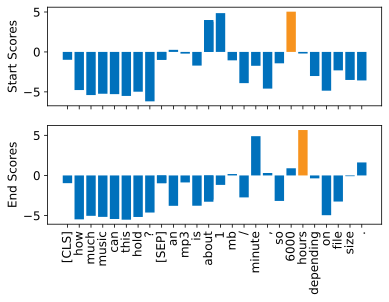

In [108]:
# 시작 토큰과 종료 토큰에 대한 예측 로짓. 오렌지 색 토큰이 가장 높은 점수를 가진 토큰입니다.
# 이 그래프는 다음을 참고했습니다. https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=tokens, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=tokens, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(rotation="vertical")
plt.show()

In [109]:
import torch 

start_idx = torch.argmax(start_logits)  
end_idx = torch.argmax(end_logits) + 1  
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"질문: {question}")
print(f"답변: {answer}")

질문: How much music can this hold?
답변: 6000 hours


- 트랜스포머스는 편리하게도 이런 모든 전처리 단계와 후처리 단계가 전용 파이프라인 안에 있다.
- 다음처럼 토크나이저와 미세 튜닝된 모델을 전달해 파이프라인을 초기화합니다.

In [110]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

[{'score': 0.2651616632938385, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.2208297699689865,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253509134054184,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

- 답변 외에도, 이 파이프라인은 모델이 추정한 확률을 score 필드로 제공한다.
- 한 문맥에서 여러 답을 비교할 때 편리하다.
- 또 topk 매개변수를 사용하면 모델이 여러 개의 답을 예측한다.
- answers.answer_start가 비어있는 SubjQA 샘플처럼 이따금 답변이 불가한 질문도 있다.
- 모델은 이 경우 [CLS] 토큰에 높은 싲가 점수와 종료 점수를 할당한다.
- 파이프라인은 이 출력을 빈 문자열로 매핑한다.

In [111]:

pipe(question="Why is there no data?", context=context, 
     handle_impossible_answer=True)

{'score': 0.9068408012390137, 'start': 0, 'end': 0, 'answer': ''}

#### 긴 텍스트 다루기
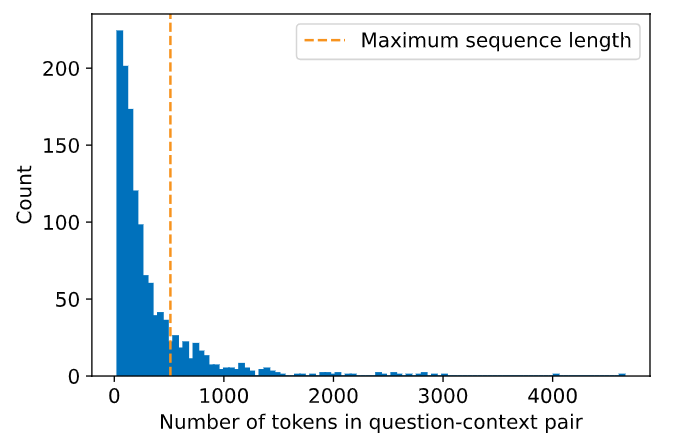
- 독해 모델의 결점 하나는 종종 문맥에 있는 토큰이 모델의 최대 시퀀스 길이(보통 최대 수 백개 토큰)를 초과한다는 것입니다.
- SubjQA 훈련 세트의 상당 부분이 MiniLM의 문맥 크기인 512 토큰에 맞지 않는 질문-문맥 쌍을 가집니다.
- 텍스트 분류와 같은 그 외 작업에서는 정확한 예측을 생성하기 위해 [CLS] 토큰 임베딩에 충분한 정보가 담겼다고 가정하고 그냥 텍스트를 자랐습니다.
- 하지만 QA 작업에서는 이런 전략이 문제를 일으킵니다.
- 질문의 답이 문맥의 끝에 있으면 텍스트를 잘랐을 때 답이 삭제된다.
- 이 문제를 다루는 전형적인 방법은 입력에 슬라이딩 윈도를 적용하느 것입니다.
- 각 윈도는 모델의 문맥 크기에 맞는 토큰 리스트가 된다.
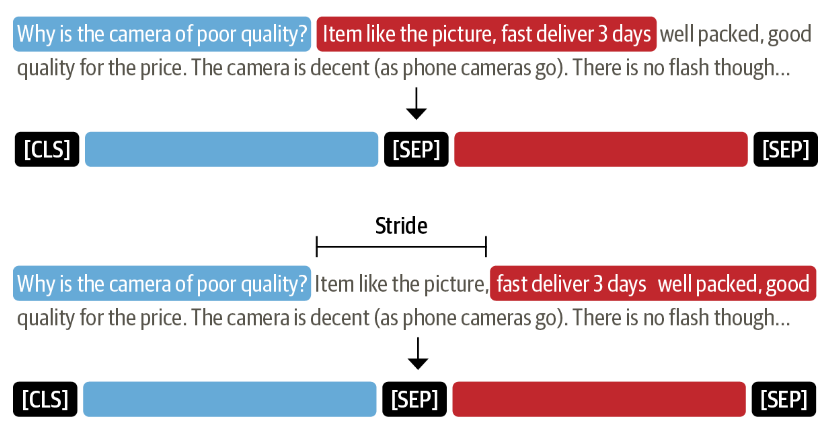

- 트랜스포머스는 토크나이저에 return_overflowing_tokens=True를 설정해 슬라이딩 윈도우를 만든다.
- 슬라이딩 윈도우의 크기는 max_seq_length 매개변수로, 스트라이드의 크기는 doc_stride로 조절한다.
- 훈련 세트에 첫번째 샘플을 사용해 슬라이딩 윈도의 작동 방식을 확인하겠다

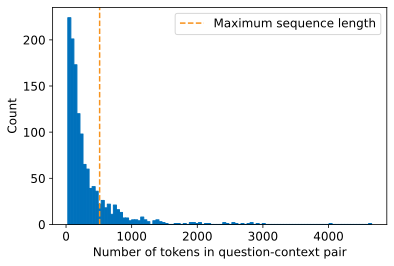

In [112]:
# SubjQA 훈련 세트에 있는 질문-문맥 쌍의 토큰 분포
def compute_input_length(row):
    inputs = tokenizer(row["question"], row["context"])
    return len(inputs["input_ids"])

dfs["train"]["n_tokens"] = dfs["train"].apply(compute_input_length, axis=1)

fig, ax = plt.subplots()
dfs["train"]["n_tokens"].hist(bins=100, grid=False, ec="C0", ax=ax)
plt.xlabel("Number of tokens in question-context pair")
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1", 
           label="Maximum sequence length")
plt.legend()
plt.ylabel("Count")
plt.show()

In [113]:

example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"], 
                              return_overflowing_tokens=True, max_length=100, 
                              stride=25)

In [114]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"#{idx} 윈도에는 {len(window)}개의 토큰이 있습니다.")

#0 윈도에는 100개의 토큰이 있습니다.
#1 윈도에는 88개의 토큰이 있습니다.


In [115]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and
qz - 99. the koss portapro is portable and has great bass response. the work
great with my android phone and can be " rolled up " to be carried in my
motorcycle jacket or computer bag without getting crunched. they are very light
and don't feel heavy or bear down on your ears even after listening to music
with them on all day. the sound is [SEP]

[CLS] how is the bass? [SEP] and don't feel heavy or bear down on your ears even
after listening to music with them on all day. the sound is night and day better
than any ear - bud could be and are almost as good as the pro 4aa. they are "
open air " headphones so you cannot match the bass to the sealed types, but it
comes close. for $ 32, you cannot go wrong. [SEP]



- 이제 QA 모델이 텍스트에서 답을 추출하는 방법을 이해했으니 end-to-end QA 파이프라인을 만드는 데 필요한 다른 구성 요소를 알아보겠다.

### 3) 헤이스택을 사용해 QA 파이프라인 구축하기
- 앞서 간단한 답변 추출 예제에서는 질문과 문맥을 모두 모델에 제공했다.
- 하지만 시스템의 실제 사용자는 제품에 대한 질문만 제공한다.
- 따라서 말뭉치에 있는 전체 리뷰 중 관련된 텍스트를 선택할 방법이 필요하다.
- 이를 수행하는 방법 하나는 해당 제품의 리뷰를 모두 연결해 하나의 긴 문맥으로 만들어 모델에 주입하는 것이다.
- 이 방법은 간단하지만 문맥이 극도로 길어져 때로는 사용자 쿼리에 대한 레이턴시를 수용하지 못한다는 단점이 있다.
- 예를 들어 제품마다 평균적으로 30개의 리뷰를 처리한다면 사용자 쿼리마다 평균 3초의 레이턴시가 발생한다.
- 전자상거래 웹사이트에서 너무 긴 시간이다.
- 최신 QA 시스템은 두 가지 주요 구성 요소로 이루어진 리트리버-리더 구조를 기반으로 이 문제를 처리한다.

#### 리트리버
- 쿼리에서 관련된 문서를 추출한다.
- 리트리버는 일반적으로 희소 아니면 밀집으로 구분한다.
- 희소 리트리버는 단어 빈도를 사용해 각 문서와 쿼리를 희소 벡터로 표현한다.
- 반면 밀집 리트리버는 트랜스포머 같은 인코더를 사용해 쿼리와 문서를 문맥화된 임베딩으로 표현한다.
- 이런 임베딩이 의미를 인코딩하므로 밀집 리트리버는 쿼리의 내용을 이해해 검색 정확도를 향상 시킨다.

#### 리더
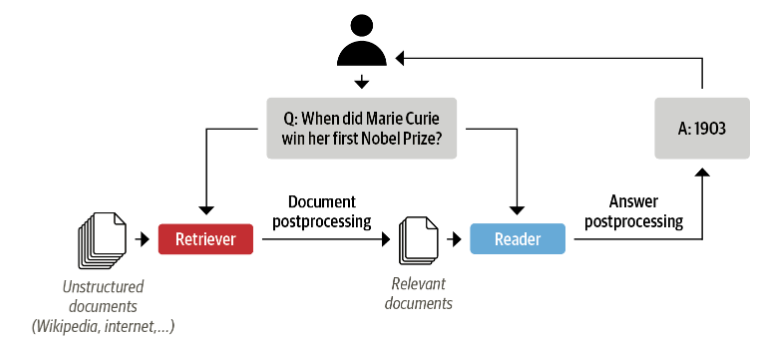
- 리트리버가 제공한 문서에서 답을 추출한다.
- 리더는 대게 독해 모델이지만 이 장의 끝에서 자유 형식의 답변을 생성하는 모델을 살펴보겠다.
- 리트리버가 추출한 문서나 리더가 추출한 답에 후처리를 적용하는 구성요소도 있습니다.
- 예를 들어 리더에 혼돈을 일으키는 잡음이나 관련 없는 요소를 제외하기 위해 추출된 문서를 다시 랭킹하는 작업을 진행합니다.
- 마찬가지로 긴 문서에 있는 여러 구절에서 정답이 나오면 종종 리더의 답을 후처리할 필요가 있습니다.
- QA 시스템을 만들기 위해, NLP 전문 돌익 기업 딥셋이 개발한 헤이스택 라이브러리를 사용하겠다.
- 헤이스택은 리트리버-리더 아키텍처를 기반으로 하고, 이런 시스템 구축과 관련된 많은 복잡도를 추상화하며 트랜스포머스와 긴말하게 통합됐다.
- 헤이스택으로 QA 파이프라인을 만들 때는 리트리버와 리더 외에 두가지 구성 요소가 더 있습니다.

#### 문서 저장소
- 쿼리 시점에 리트리버로 제공하는 문서와 메타데이터를 저장하는 문서 전용 데이터베이스입니다.

#### 파이프라인
- 사용자 쿼리가 잘 흘러가도록 QA 시스템의 모든 구성 요소를 결합하고 여러 리트리버에서 추출한 문서를 합치는 등의 기능을합니다.
- 이 절에서는 이런 구성 요소를 사용해 프로토타입 QA 파이프라인을 빠르게 구축하는 방법을 알아보겠다.
- 그 뒤에는 성능을 높이는 방법도 살펴보겠다.

#### 문서 저장소 초기화하기
- 헤이스택에서 사용 가능한 문서 저장소는 다양하며, 저장소마다 조합할 수 있는전용 리트리버가 있다.
- 희소 리트리버(TF-IDF, BM25)와 밀집 리트리버(Embedding, DPR)에 각각 호환디는 문서 저장소를 정리했다.
- 희소 리트리버와 밀집 리트리버를 이 장에서 모두 살펴보므로 양쪽 리트리버에 모두 화환되는 ElasticsearchDocumentStore를 사용하겠습니다.
- 일래스틱서치는 텍스트, 수치, 지리 데이터, 구조적 데이터, 비구조적 데이터를 포함해 다양한 데이터 타입을 처리하는 검색 엔진이다.
- 대용량 데이터를 저장하고 전체 텍스트 검색으로 빠르게 필터링하므로 특히 QA 시스템 개발에 잘 맞습니다.
- 인프라 분석을 위한 업계 표준이라는 이점도 있다.
- 따라서 회사에서는 이미 일래스틱서치 클러스터가 있을 가능성이 높다.
- 문서 저장소를 초기화하려면 먼저 일래스틱서치를 다운로드하고 설치해야 합니다.
- 일랙스틱서치 가이드를 따라 wget으로 최신 리눅스용 릴리스를 다운로드하고 tar 셸 명령으로 압축을 풉니다.

In [116]:

url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.3-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.3-linux-x86_64.tar.gz

- 이 서브프로세스를 주피터 노트북에서 실행하기 때문에 파이썬의 Popen() 함수를 사용해 새로운 프로세스를 시작한다.
- 백그라운드에서 실행하기 위해 chown 셸명령을 사용해야한다.

In [117]:
import os
from subprocess import Popen, PIPE, STDOUT

# 백그라운드 프로세스로 일래스틱서치를 실행합니다
!chown -R daemon:daemon elasticsearch-7.9.3
es_server = Popen(args=['elasticsearch-7.9.3/bin/elasticsearch'],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# 일래스틱서치가 시작할 때까지 기다립니다
!sleep 30

- Popen() 함수에서 args로 실행할 프로그램을 지정한다.
- stdout=PIPE는 표준 출력을 위해 새로운 파이프를 만들고 stdder=STDOUT로 지정하면 동일한 파이프로 에러가 수집됩니다.
- preexec_fn 매개변수에 사용할 서브프로세스의 아이디를 지정합니다.
- 기본적으로 일래스틱 서치는 포트 9200으로 로컬에서 실행됩니다.
- 따라서 localhost로 HTTP 요청을 보내서 연결을 테스트 합니다.

In [118]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "0eb499bea078",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "NuDRjh_ZRU-8Z4p8hlefHA",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [119]:

from haystack.document_store.elasticsearch import ElasticsearchDocumentStore

# 밀집 리트리버에서 사용할 문서 임베딩을 반환합니다.
document_store = ElasticsearchDocumentStore(return_embedding=True)

In [120]:
# 노트북을 다시 시작할 때 일래스틱서치 저장소를 모두 비우는 것이 좋습니다.
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents("document")
    document_store.delete_documents("label")

- 기본적으로 ElasticsearchDocumentStore는 일래스틱서치에 두 개의 인덱스를 만듭니다.
- 문서를 저장하는 document와 답의 범위를 저장하는 label입니다.
- 여기에서는 SubQA 리뷰로 document 인덱스를 채우겠습니다.
- 헤이스택 문서 저장소는 다음처럼 text_meta 키를 가진 딕셔너리의 리스트릴 기대합니다
- meta에 있는 필드를 사용해 검색 괒어에서 필터를 적용합니다.
- 제품과 질문 ID로 필터링할 수 있도록 SubjQA의 item_id와 id 열 
- 그리고 해당되는 분할 이름을 포함시키겠습ㄴ디ㅏ.
- 다음처럼 DataFrame에 있는 샘플을 순회하면서 write_documents()메서드로 인덱스에 추가합니다.

In [121]:
for split, df in dfs.items():
    # 중복 리뷰를 제외시킵니다
    docs = [{"text": row["context"], 
             "meta":{"item_id": row["title"], "question_id": row["id"], 
                     "split": split}} 
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs, index="document")
    
print(f"{document_store.get_document_count()}개 문서가 저장되었습니다")

1615개 문서가 저장되었습니다


#### 리트리버 초기화하기
- 일래스틱서치 문서 저장소는 모든 헤이스택 리트리버와 조합이 가능하다.
- BM25 기반의 희소 리트리버를 먼저 사용해보죠
- BM25는 고전적인 TF-IDF 알고리즘을 개선한 버전으로 일래스틱서치에서 효율적으로 검색할 수 있는 희소벡터로 질문과 문맥을 표현합니다.
- BM25 점수는 검색 쿼리에서 얼마나 많은 텍스트가 일치하는지 측정합니다.
- 그 다음 TF 값을 빠르게 포화시키고 짧은 문서가 긴 문서보다 선호되도록 문서 길이로 정규화해 TF-IDF를 개선합니다.
- 헤이스택에서 ElasticsearchRetriever의 기본 리트리버는 BM25dlek.
- 검색하려는 문서 저장소를 지정해 이 클래스의 객체를 만들어 보자

In [122]:
from haystack.retriever.sparse import ElasticsearchRetriever

es_retriever = ElasticsearchRetriever(document_store=document_store)

- 훈련 세트에 있는 한 전자 제품에 대한 간단한 쿼리를 살펴보겠다.
- 리뷰 기반 QA 시스템에서는 단일 시스템에서는 단일 아이템으로 쿼리를 제한하는 것이 중요합니다.
- 그렇지 않으면 리트리버가 사용자 쿼리와 무관한 제품의 리뷰도 검색합니다.
- 예를 들어 제품 필터링 없이 휴대폰 리뷰가 반환되는 경우가 생깁니다.
- 사용자가 마케라 성능을 물어본 제품은 사실 랩톱 컴퓨터일지 모릅니다.
- 데이터셋에 있는 ASIN값은 암호처럼 보이지만 아마존 ASIN 같은 온라인 도구나 www.amazon.com/dp/ 주소뒤에 item_id 값을 추가하면 해독이 됩니다.
- 다음 아이템 ID는 아마존파이어 태블릿 ID 입니다.
- 리트리버의 retrieve() 메서드를 사용해 이 제품이 독서에 유용하지 물어보죠

In [123]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = es_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

- top_k 매개변수로 얼마나 많은 문서를 반환할지 지정하고 문서의 meta 필드에 포함시킨 item_id와 split 키에 모두 필터를 적용했습니다.
- retrieved_docs의 각 원소는 문서를 나타내는 데 사용하는 헤이스택의 Document 객체이고 리트리버의 쿼리 점수와 그 외 메타 데이터를 포함합니다.


In [124]:
print(retrieved_docs[0])

{'text': 'This is a gift to myself.  I have been a kindle user for 4 years and
this is my third one.  I never thought I would want a fire for I mainly use it
for book reading.  I decided to try the fire for when I travel I take my laptop,
my phone and my iPod classic.  I love my iPod but watching movies on the plane
with it can be challenging because it is so small. Laptops battery life is not
as good as the Kindle.  So the Fire combines for me what I needed all three to
do. So far so good.', 'score': 6.1138525, 'probability': 0.6822717459457631,
'question': None, 'meta': {'item_id': 'B0074BW614', 'question_id':
'868e311275e26dbafe5af70774a300f3', 'split': 'train'}, 'embedding': None, 'id':
'252e83e25d52df7311d597dc89eef9f6'}


- 문서 텍스트 외에 일래스틱서치가 쿼리와의 연관성을 계산한 score 필드가 출력됩니다.
- 점수가 높을수록 매칭이 더 잘됐음을 의미합니다
- 내부적으로 일래스틱서치는 인덱싱과 검색을 위해 루씬에 의존합니다.
- 따라서 기본적으루 루씬의 실용적인 스코어링 함수를 사용합니다.
- 스코어링 함수는 일래스틱서치 문서에서 자세히 설명합니다.
- 간단히 요약하면 스코어링 함수는 불언 텍스트를 사용해 후보 문서를 필터링한 다음 문서와 쿼리의 벡터 표현을 기반으로 유사도를 측정합니다.
- 이제 관련된 문서를 추출할 방법이 준비됐으니 이런 문서에서 답을 추출할 방법이 필요합니다.
- 여기에 리더가 사용되므로 헤이스택에 MiniLM 모델을 로드하는 방법을 알아보겠습니다.

#### 리더 초기화하기
- 헤이스택에느 주어진 문맥에서 답을 추출하는 두 종류의 리더가 있습니다.

##### FARMReader
- 트랜서포머를 미세튜닝하고 배포하는 딥셋 FARM 프레임워크를 기반으로 합니다.
- 트랜스포머스를 사용해 훈련된 모델과 호환되며 허깅페이스 허브에서 바로 모델을 로드할수 있습니다.

##### TransformersReader
- 트랜스포머스의 QA 파이프라인을 기반으로 합니다.
- 추론만 실행하는 데 적합합니다.
- 두 리더가 모델의 가중치를 같은 방식으로 처리하지만 예측을 변환해 답을 만드는 방식은 조금 다릅니다.
    - 트랜스포머스에서 QA 파이프라인은 각 구절의 시작로짓과 종료 로짓을 소프트맥스로 정규화합니다.
    - 따라서 확률의 합이 1이 되는 같은 구절에서 추출한 답의 점수를 비교할 때만 의미 있습니다.
    - 예를 들어 한 구절에서 점수가 0.9인 답이 다른 구절에서 0.8을 얻은  답보다 반드시 더 좋지는 않습니다.
    - FARM에서는 로짓을 정규화하지 ㅇ낳아 구절 간의 답변이 더 쉽게 비교됩니다.
    
    
    - TransformersReader는 이따금 같은 답을 다른 점수로 두 번 예측합니다. 가령 문맥이 길고 답이 중첩된 윈도에 놓인 경우 그렇습니다. FARM에서는 이런 중복을 제거합니다.
    
- 이 장의 후반부에서 리더를 미세 튜닝하기 위해 FARMReader를 사용하겠습니다.
- 트랜스포머스와 마찬가지로 모델을 로드하려면 QA특화된 매개변수와 함께 허깅페이스 허브에 있는 MiniLM 체크포인트를 지정하면 됩니다.

In [125]:
from haystack.reader.farm import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride, 
                    return_no_answer=True)

- FARMReader에서 슬라이딩 윈도의 동작은 토크나이저에서 본 것과 같은 max_seq_length와 doc_stride 매개변수로 제어된다.
- 여기서는 MiniLM 논문에 있는 값을 사용했습니다.
- 동작을 확인하기 위해 앞의 간단한 예로 테스트해보자

In [126]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.6480952501297,
'answers': [{'answer': '6000 hours', 'score': 10.699627876281738, 'probability':
0.3988158404827118, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours
depending on file size.', 'offset_start': 38, 'offset_end': 48,
'offset_start_in_doc': 38, 'offset_end_in_doc': 48, 'document_id':
'e344757014e804eff50faa3ecf1c9c75'}]}


/opt/conda/lib/python3.7/site-packages/farm/modeling/prediction_head.py:1167: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  start_indices = flat_sorted_indices // max_seq_len


#### 모두 합치기
- 헤이스택은 리트리버, 리더와 그 외 구성 요소를 연결해 사례에 따라 쉽게 커스터마이징 가능한 그래프로 구성하는 Pipeline 추상화를 제공합니다.
- 트랜스포머스에 있는 파이프라인과 비슷하지만 QA 시스템에 특화된 사전 정의된 파이프라인도 있습니다.
- 이 경우 답 추출에 관심이 있으므로 매개변수로 하나의 리트리버-리더쌍을 받는 ExtractiveQAPipeline을 사용하겠습니다.

In [127]:
from haystack.pipeline import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, es_retriever)

- 각 Pipeline은 쿼리가 어떻게 실행 되어야 하는지 지정하는 run() 메서드가 있습니다.
- ExtraciveQAPipeline의 경우 query, top_k_retriever로 추출할 문서 개수
- top_k_reader로 문서에서 추출할 답 개수를 전달합니다.
- 이 경우 아이템ID에 대한 필터도 지정해야 합니다
- 이는 앞서 리트리버에서 한 것처럼 filters 매개변수를 사용해 처리합니다.
- 아마존 파이어 태블릿에 대한 질문 예를 다시 실행해보죠
- 하지만 이번에는 추출된 답을 반환합니다.


In [128]:
n_answers = 3
preds = pipe.run(query=query, top_k_retriever=3, top_k_reader=n_answers,
                 filters={"item_id": [item_id], "split":["train"]})

print(f"질문: {preds['query']} \n")
for idx in range(n_answers):
    print(f"답변 {idx+1}: {preds['answers'][idx]['answer']}")
    print(f"해당 리뷰 텍스트: ...{preds['answers'][idx]['context']}...")
    print("\n\n")

질문: Is it good for reading?

답변 1: I mainly use it for book reading
해당 리뷰 텍스트: ... is my third one.  I never thought I would want a fire for I
mainly use it for book reading.  I decided to try the fire for when I travel I
take my la...



답변 2: the larger screen compared to the Kindle makes for easier reading
해당 리뷰 텍스트: ...ght enough that I can hold it to read, but the larger screen
compared to the Kindle makes for easier reading. I love the color, something I
never thou...



답변 3: it is great for reading books when no light is available
해당 리뷰 텍스트: ...ecoming addicted to hers! Our son LOVES it and it is great for
reading books when no light is available. Amazing sound but I suggest good
headphones t...





# 2. QA 파이프라인 개선하기
- 최근 많은 QA 연구는 독해 모델을 개선하는 데 집중하지만
- 사실 먼저 리트리버가 관련된 문서를 찾지 못한다면 리더의 성능이 얼마나 좋을지는 중요하지 않습니다.
- 특히 리트리버는 전체 QA 시스템 성능의 상한선을 설정하므로 리트리버의 성능을 높이는 것이 중요합니다.
- 이런 점을 유념하고 리트리버를 평가해 희소와 밀집 표현의 성능을 비교할 수 있는 일반적인 지표를 몇 가지 소개하겠습니다.

### 1) 리트리버 평가하기
- 리트리버를 평가하는 일반적인 지표 하나는 추출된 관련 문서의 비율을 측정하는 재현율이다.
- 여기서 관련일나 표현은 단순히 답이 텍스트 안에 있는지 없는지를 의미한다.
- 따라서 인련의 질문이 주어지면 리트리버가 반환한 최상위 k개 문서에 답이 등자한 횟수를 카운트해 재현율을 계산합니다.
- 헤이스택에서 리트리버를 평가하는 방법은 두가지이다.
    - 리트리버가 제공하는 eval() 메서드를 사용한다. eval()은 오픈 도메인과 클로즈드 도메인 QA에 모두 사용할수 있다. 하지만 각 문서가 하나의 제품과 쌍을 이루어 모든 쿼리에서 제품 ID를 필터링해야 하는 SubjQA와 같은 데이터셋에서는 사용하지 못한다
    - EvalDocuments 클래스와 리트리버를 결합하는 사용자의 정의 Pipeline을 만든다. 이를 통해 사용자 정의 지표와 쿼리 흐름을 구현한다.
    


> 재현율을 보완하는 지표는 mAP이다. 문서 순위에서 정답을 높은 위치에 놓은 리트리버에 보상을 제공합니다.
> 우리는 제품마다 재현율을 평가하고 그 결과를 수집해야 하므로 두 번째 방법을 사용하겠다. Pipeline 그래프에 있는 각 노드는 어떤 입력을 받고 run()메서드로 어떤 출력을 만드는 하나의 클래스를 나타낸다.

In [81]:
# class PipelineNode:
#     def __init__(self):
#         self.outgoing_edges = 1
        
#     def run(self, **kwargs):
#         ...
#         return (outputs, "outgoing_edge_name")

- kwargs는 그래프에 있는 이전 노드의 출려에 해당합니다.
- 다음 노드를 위해 출력의 튜플과 노드에서 나가는 edge의 이름을 반환하가 위해 run() 메서드 안에서 처리됩니다.
- 이외에 유일한 요구사항은 노드의 출력 개수를 나타내는 outgoing_edges 속성을 포함하는 것입니다.
- 어떤 조건에 따라 입력을 라우팅하는 브랜치가 파이프라인에 없다면 대부분 outgoing_edges=1입니다.)
- 여기에서는 리트리버를 평가할 노드가 필요합니다. 
- 따라서 run()메서드에서 정답이 있는 문서를 추적하는 evalDocuments 클래스를 사용하겠습니다.
- 그 다음 리트리버를 표현한 노드 뒤에 평가 노드를 추가해 Pipeline 그래프를 만듭니다.

In [129]:
from haystack.pipeline import Pipeline
from haystack.eval import EvalDocuments

class EvalRetrieverPipeline:
    def __init__(self, retriever):
        self.retriever = retriever
        self.eval_retriever = EvalDocuments()
        pipe = Pipeline()
        pipe.add_node(component=self.retriever, name="ESRetriever", 
                      inputs=["Query"])
        pipe.add_node(component=self.eval_retriever, name="EvalRetriever", 
                      inputs=["ESRetriever"])
        self.pipeline = pipe


pipe = EvalRetrieverPipeline(es_retriever)

- 각 노드는 name 매개변수와 리스트로 inputs 매개변수를 지정합니다.
- 대게 노드는 출력 에지가 하나입니다. 
- 따라서 그냥 inputs에 이전 노드의 이름을 포함시키면 됩니다.

- 평가 파이프라인을 만들었으나 쿼리와 이에 해당하는 답을 전달해야 합니다.
- 이를 위해 문서 저장소에 있는 전용 label 인덱스에 답을 추가하겠습니다.
- 헤이스텍은 표준 방식으로 답 범위와 메타데이터를 나타내는 Lebel 객체를 제공합니다.
- label 인덱스를 채우기 위해 먼저 테스트 세트에 있는 질문을 순회하면서 답과 추갖거인 메타데이터를 추출해 Label 객체의 리스트를 만들겠습니다.

In [130]:
from haystack import Label

labels = []
for i, row in dfs["test"].iterrows():
    # 리트리버에서 필터링을 위해 사용하는 메타데이터
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # 답이 있는 질문을 레이블에 추가합니다
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                question=row["question"], answer=answer, id=i, origin=row["id"],
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False)
            labels.append(label)
    # 답이 없는 질문을 레이블에 추가합니다
    else:
        label = Label(
            question=row["question"], answer="", id=i, origin=row["id"],
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True)  
        labels.append(label)

In [131]:
print(labels[0])

{'id': '187e5c5c-c5d1-4e01-bfd1-20d6bbd9e3b3', 'created_at': None, 'updated_at':
None, 'question': 'What is the tonal balance of these headphones?', 'answer': 'I
have been a headphone fanatic for thirty years', 'is_correct_answer': True,
'is_correct_document': True, 'origin': 'd0781d13200014aa25860e44da9d5ea7',
'document_id': None, 'offset_start_in_doc': None, 'no_answer': False,
'model_id': None, 'meta': {'item_id': 'B00001WRSJ', 'question_id':
'd0781d13200014aa25860e44da9d5ea7'}}


- 질문 답변 쌍과 쿼리마다 문서 저장소를 필터링할 수 있는 고유한 질문 ID가 담긴 origin 필드가 있다.
- 또 제품으로 레이블을 필터링하기 위해 meta 필드에 제품 ID를 추가했다.
- 레이블이 준비됐으니 다음처럼 일래스틱서치의 label 인덱스에 저장한다.

In [132]:
document_store.write_labels(labels, index="label")
print(f"""{document_store.get_label_count(index="label")}개의 \
질문 답변 쌍을 로드했습니다.""")

358개의 질문 답변 쌍을 로드했습니다.


- 다음 파이프라인에 전달하기 위해 질문 ID와 이에 상응하는 답변을 매핑한다.
- 전체 레이블을 얻기 위해 문서 저장소의 get_all_labels_aggregated() 메서드를 사용해 고유 ID를 가진 모든 질문-답변 쌍을 가져오겠습니다.
- 이 메서드는 MultiLabel 객체의 리스트를 반환합니다.
- 하지만 이 예제에서는 질문 ID로 필터링하기 때무넹 하나의 원소만 반환한다.
- 다음 코드를 실행하면 레이블의 리스트를 만든다.

In [133]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

330


- 레이블 하나를 살펴보면 지룸ㄴ 하나에 연관된 모든 답이 multiple_answers 필드에 들어 있습니다. 

In [87]:
print(labels_agg[100])

{'question': 'How is the quality of the handle?', 'multiple_answers': [''],
'is_correct_answer': True, 'is_correct_document': True, 'origin':
'9e940b0b084cc8608c01a25492de2959', 'multiple_document_ids': [None],
'multiple_offset_start_in_docs': [None], 'no_answer': True, 'model_id': None,
'meta': {'item_id': 'B002J9HBIO'}}


- 리트리버를 평가할 요소를 모두 갖췄습니다.
- 이번에는 각 제품에 연관된 질문-답 쌍을 평가 파이프라인에 주입하고 pipe 객체에서 추출이 올바르게 되는지 추적한느 함수를 정의해보자

In [134]:
def run_pipeline(pipeline, top_k_retriever=10, top_k_reader=4):
    for l in labels_agg:
        _ = pipeline.pipeline.run(
            query=l.question,
            top_k_retriever=top_k_retriever,
            top_k_reader=top_k_reader,
            top_k_eval_documents=top_k_retriever,    
            labels=l,
            filters={"item_id": [l.meta["item_id"]], "split": ["test"]})

In [135]:
run_pipeline(pipe, top_k_retriever=3)
print(f"재현율@3: {pipe.eval_retriever.recall:.2f}")

재현율@3: 0.95


- 추출한 문서 개수를 위해 top_k_retriever에 특정 값을 지정했습니다.
- 일반적으로 이 매개변수를 증가시키면 재현율이 향상되지만 리더에 더 많은 문서를 제공하는 대가로 end-to-end 파이프라인이 느려진다.
- 어떤 값을 선택할지 결정할 때 도움이 되도록 몇 개의 k 값을 반복하고 각 k에서 전체 테스트 세트의 재현율을 계삲나느 함수를 만들겠다.

In [137]:
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}

    for topk in topk_values:
        # 파이프라인을 만듭니다
        p = EvalRetrieverPipeline(retriever)
        # 테스트 세트에 있는 질문-답변 쌍을 반복합니다
        run_pipeline(p, top_k_retriever=topk)
        # 재현율을 저장합니다
        topk_results[topk] = {"recall": p.eval_retriever.recall}
        
    return pd.DataFrame.from_dict(topk_results, orient="index")


es_topk_df = evaluate_retriever(es_retriever)

- 결과를 그래프로 그려 k가 증가함에 따라 재현율이 어떻게 향상되는지 확인하겠습니다.

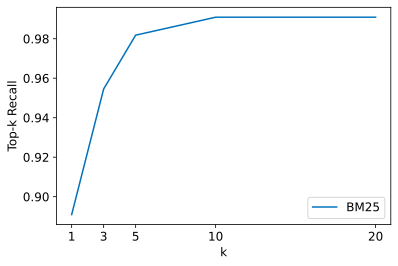

In [138]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y='recall', ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel('Top-k Recall')
    plt.xlabel('k')
    plt.show()
    
plot_retriever_eval([es_topk_df], ['BM25'])

- k=5에서 변곡점이 있고 k=10부터 거의 완벽한 재현율을 달성한다.
- 그럼 이제 밀집 벡터 기법으로 추출한 문서를 확인해보자

#### DPR
- 희소 리트리버는 k=10개 문서를 반환할 때 거의 완벽한 재현율을 달성했다.
- 하지만 k 값이 그보다 작을 때 성능을 높일 방법이 있을까?
- 이렇게 하면 더 적은 개수의 문서를 리더로 보내 QA 파이프라인의 전체적인 레이턴시를 줄이다는 이점이 생긴다.
- BM25 같은 희소 리트리버의 주요 단점은 사용자 쿼리의 단어가 리뷰에 들어있지 않으면 연관된 문서를 검색하지 못할 수 있다는 것이다.
- 한 가지 희망적인 대안은 밀집 임베딩을 사용해 질문과 문서를 표현하는 것이다.
- DPR이라 불리는 구조가 현재 최고의 성능을 달성한다.
- DPR은 두개의 BERT 모델을 사용해 질문과 구절을 인코딩한다는 개념에 기반한다.
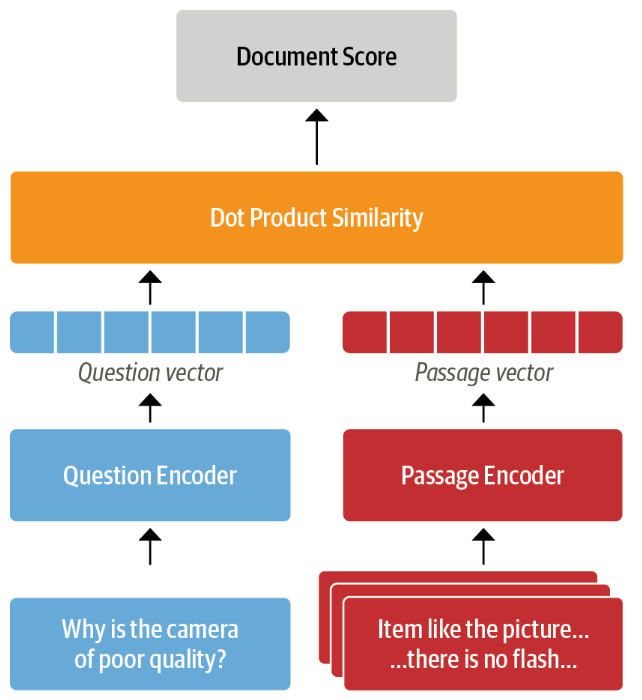
- 위의 그림처럼 인코더는 입력 텍스트를 [CLS] 토큰의 d차원 벡터 표현으로 매핑한다.
- 헤이스택에서 DPR을 위한 리트리버를 만드는 방법은 BM25 방법과 비슷하다.
- 문서 저장소를 지정하고, 질문과 구절을 위한 BERT 인코더를 선택한다.
- 선택한 인코더에 관련된 구절과 무관한 구절을 질문과 함께 주입해 훈련한다.
- 연관된 질문-구절 쌍이 높은 유사돌르 가지도록 학습하는 것이 목표이다.
- 이 예제에서는 NQ 말뭉치에서 미세튜닝한 인코더를 사용하겠다
